In [22]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from hydra import compose, initialize

from src.analysis.utils import (
    get_elsevier_single_column_fig,
    get_elsevier_double_column_fig,
    get_elsevier_figure_with_subplots
)

In [23]:
plt.rcParams.update({
    "font.size": 9,
    'lines.linewidth': 1,
})

SAVE_FIGURES = False

In [24]:
FEATURES_NAMES = {
    "V_mean": "Voltage Mean",
    "V_median": "Voltage Median",
    "V_std": "Voltage STD",
    "V_iqr": "Voltage IQR",
    "V_kurtosis": "Voltage Kurtosis",
    "V_entropy": "Voltage Entropy",
    "I_mean": "Current Mean",
    "I_median": "Current Median",
    "I_std": "Current STD",
    "I_iqr": "Current IQR",
    "I_kurtosis": "Current Kurtosis",
    "T_mean": "Temp. Mean",
    "T_median": "Temp. Median",
    "T_std": "Temp. STD",
    "T_iqr": "Temp. IQR",
    "T_kurtosis": "Temp. Kurtosis",
}

In [25]:
with initialize(version_base=None, config_path='../../src/conf'):
    cfg = compose(config_name="config")

In [26]:
figures_folder = Path('../../') / cfg['analysis']['figures_folder']
features_data_path = Path('../../') / cfg['data']['features_data_path']
train_data_path = Path('../../') / cfg['data']['train_data_path']
test_data_path = Path('../../') / cfg['data']['test_data_path']
example_cell = cfg['analysis']['example_cell']

In [27]:
features_df = pd.read_parquet(features_data_path)
train_df = pd.read_parquet(train_data_path)

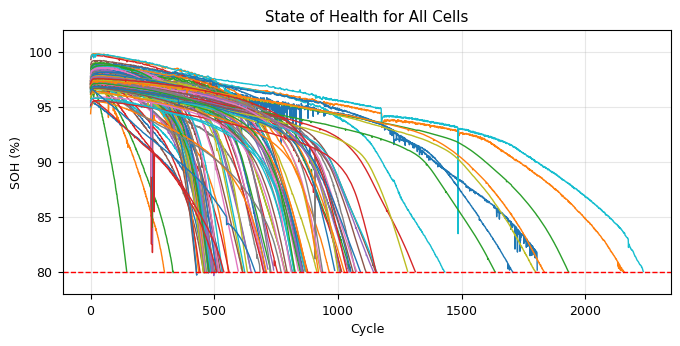

In [28]:
def plot_all_cell_soh(
    data: pd.DataFrame, 
    save_path: str = None
    ) -> None:
    fig, ax = get_elsevier_double_column_fig()
    for i, (_, cell_data) in enumerate(data.groupby('cell')):
        cell_data.sort_values('cycle', inplace=True)
        ax.plot(
            cell_data['cycle'], 
            cell_data['SOH'], 
            color=f"C{i}",
            #alpha=0.4
        )
    ax.axhline(80, color='red', linestyle='--', label='80% SOH Threshold')

    ax.set_ylim(78, 102)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('SOH (%)')
    ax.set_title('State of Health for All Cells')
    ax.grid(True, alpha=0.3)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

plot_all_cell_soh(
    features_df, 
    save_path=(
        figures_folder / 'voltage.png'
        if SAVE_FIGURES else None
    )
)

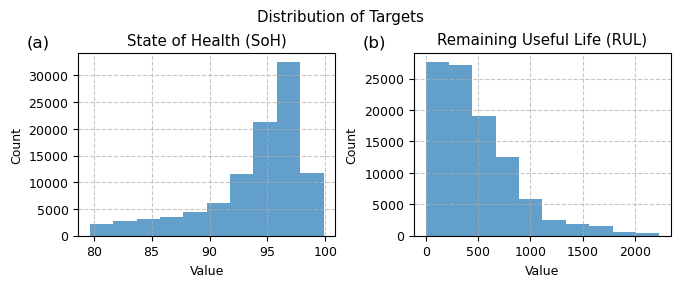

In [29]:
def plot_targets_distribution(
    data: pd.DataFrame,
    save_path: str = 'figures/targets_distribution.png'
    ) -> None:
    """Plot distribution of features for the specified cell."""
    
    soh = data['SOH']
    rul = data['RUL']
    
    fig, ax = get_elsevier_figure_with_subplots(1, 2, column='double')
    ax[0].text(-0.2, 1.1, '(a)', transform=ax[0].transAxes, fontsize=12, va='top')
    ax[1].text(-0.2, 1.1, '(b)', transform=ax[1].transAxes, fontsize=12, va='top')
    
    ax[0].hist(soh, alpha=0.7)
    ax[0].set_xlabel('Value')
    ax[0].set_ylabel('Count')
    ax[0].set_title(f"State of Health (SoH)")
    ax[0].grid(True, linestyle='--', alpha=0.7)
    
    ax[1].hist(rul, alpha=0.7)
    ax[1].set_xlabel('Value')
    ax[1].set_ylabel('Count')
    ax[1].set_title(f"Remaining Useful Life (RUL)")
    ax[1].grid(True, linestyle='--', alpha=0.7)
    
    fig.suptitle(f'Distribution of Targets')
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

plot_targets_distribution(
    features_df, 
    save_path=(
        figures_folder / 'targets_distribution.png'
        if SAVE_FIGURES else None
    )
)

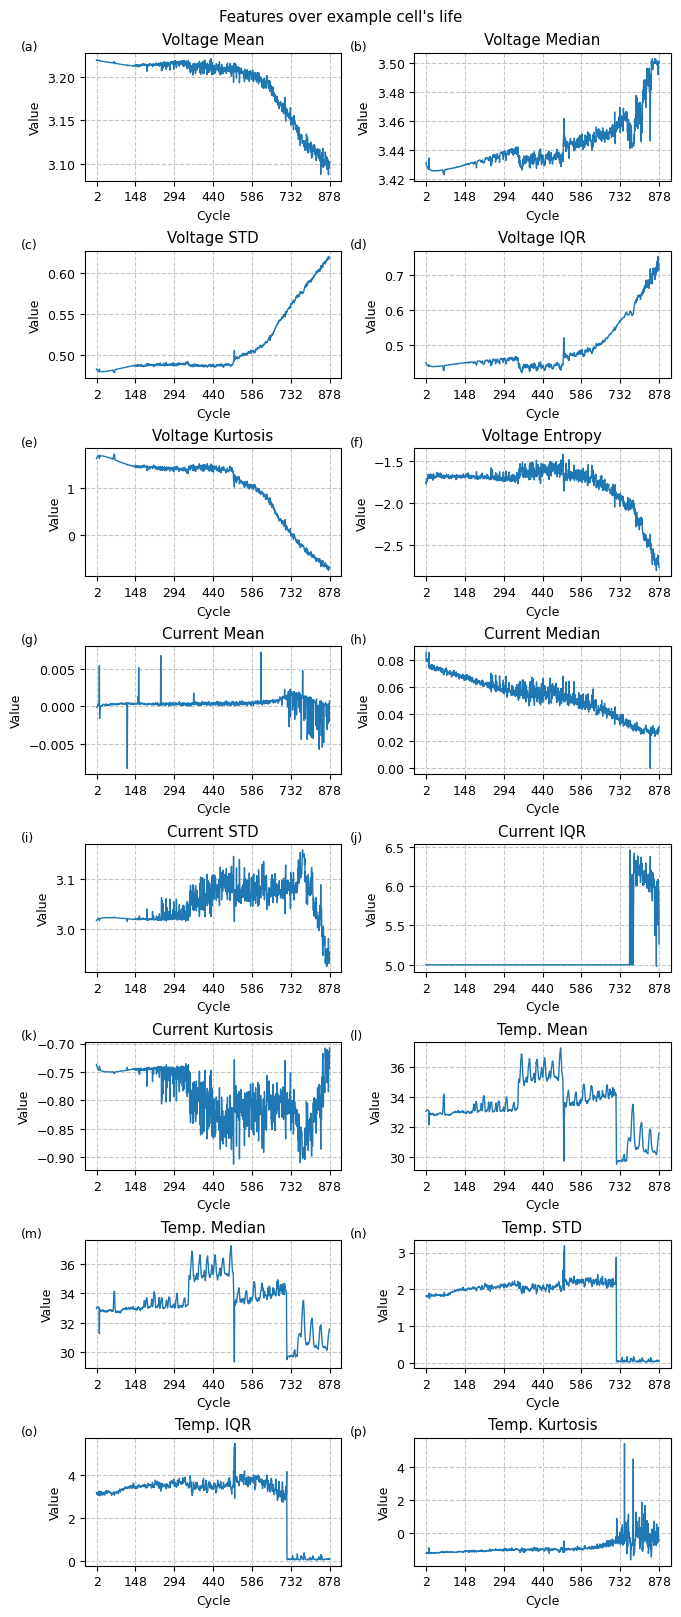

In [30]:
def plot_features(
    data: pd.DataFrame,
    save_path: str = 'figures/features.png'
    ) -> None:
    """Plot distribution of features for the specified cell."""
    
    features = FEATURES_NAMES.keys()
    num_features = len(features)

    fig, axes = get_elsevier_figure_with_subplots(8, 2, column='double', spacing_factor=0.8)
    axes = axes.flatten() if num_features > 1 else [axes]

    letters = [f'({chr(97 + i)})' for i in range(num_features)]

    for index, (feature, ax) in enumerate(zip(features, axes)):
        cycle = data[data['cell'] == example_cell]['cycle']
        values = data[data['cell'] == example_cell][feature]
        
        display_name = FEATURES_NAMES.get(feature, feature)

        ax.plot(cycle, values, color='C0')
        ax.text(-0.25, 1.1, letters[index], transform=ax.transAxes, va='top')
        ax.set_title(display_name)
        ax.set_xlabel("Cycle")
        ax.set_ylabel("Value")
        ax.set_xticks(cycle.values[1::max(1, (len(cycle)-1)//6)])
        ax.grid(True, linestyle='--', alpha=0.7)

    # Turn off extra subplots
    for ax in axes[num_features:]:
        ax.axis("off")
    
    fig.suptitle(f"Features over example cell's life")
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

plot_features(
    features_df, 
    save_path=(
        figures_folder / 'features.png'
        if SAVE_FIGURES else None
    )
)

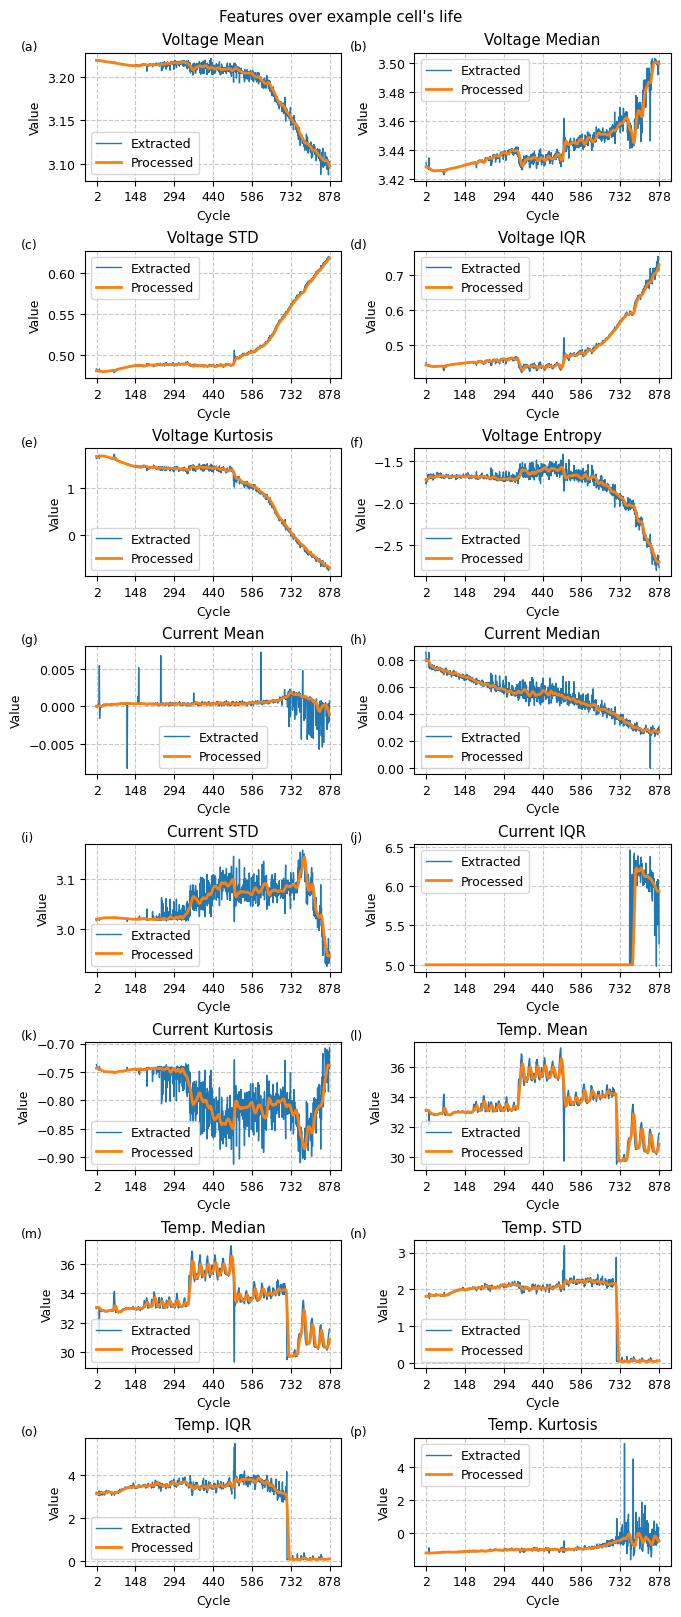

In [31]:
def plot_features_with_filter(
    data: pd.DataFrame,
    processed_data: pd.DataFrame,
    save_path: str = 'figures/features_with_filter.png'
    ) -> None:
    """Plot distribution of features for the specified cell."""

    if example_cell not in processed_data['cell'].unique():
        raise Exception(
            f"Example cell {example_cell} "
            "not on train set, can't plot filtred data."
        )

    features = FEATURES_NAMES.keys()
    num_features = len(features)

    fig, axes = get_elsevier_figure_with_subplots(8, 2, column='double', spacing_factor=0.8)
    axes = axes.flatten() if num_features > 1 else [axes]

    letters = [f'({chr(97 + i)})' for i in range(num_features)]

    for index, (feature, ax) in enumerate(zip(features, axes)):
        cycle = data[data['cell'] == example_cell]['cycle']
        values = data[data['cell'] == example_cell][feature]
        processed_values =  processed_data[processed_data['cell'] == example_cell][feature]
        
        display_name = FEATURES_NAMES.get(feature, feature)

        ax.plot(cycle, values, color='C0', label='Extracted')
        ax.plot(cycle, processed_values, color='C1', label='Processed', linewidth=2)
        ax.text(-0.25, 1.1, letters[index], transform=ax.transAxes, va='top')
        ax.set_title(display_name)
        ax.set_xlabel("Cycle")
        ax.set_ylabel("Value")
        ax.set_xticks(cycle.values[1::max(1, (len(cycle)-1)//6)])
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7)

    # Turn off extra subplots
    for ax in axes[num_features:]:
        ax.axis("off")
    
    fig.suptitle(f"Features over example cell's life")
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

plot_features_with_filter(
    features_df, 
    train_df,
    save_path=(
        figures_folder / 'features_with_filter.png'
        if SAVE_FIGURES else None
    )
)

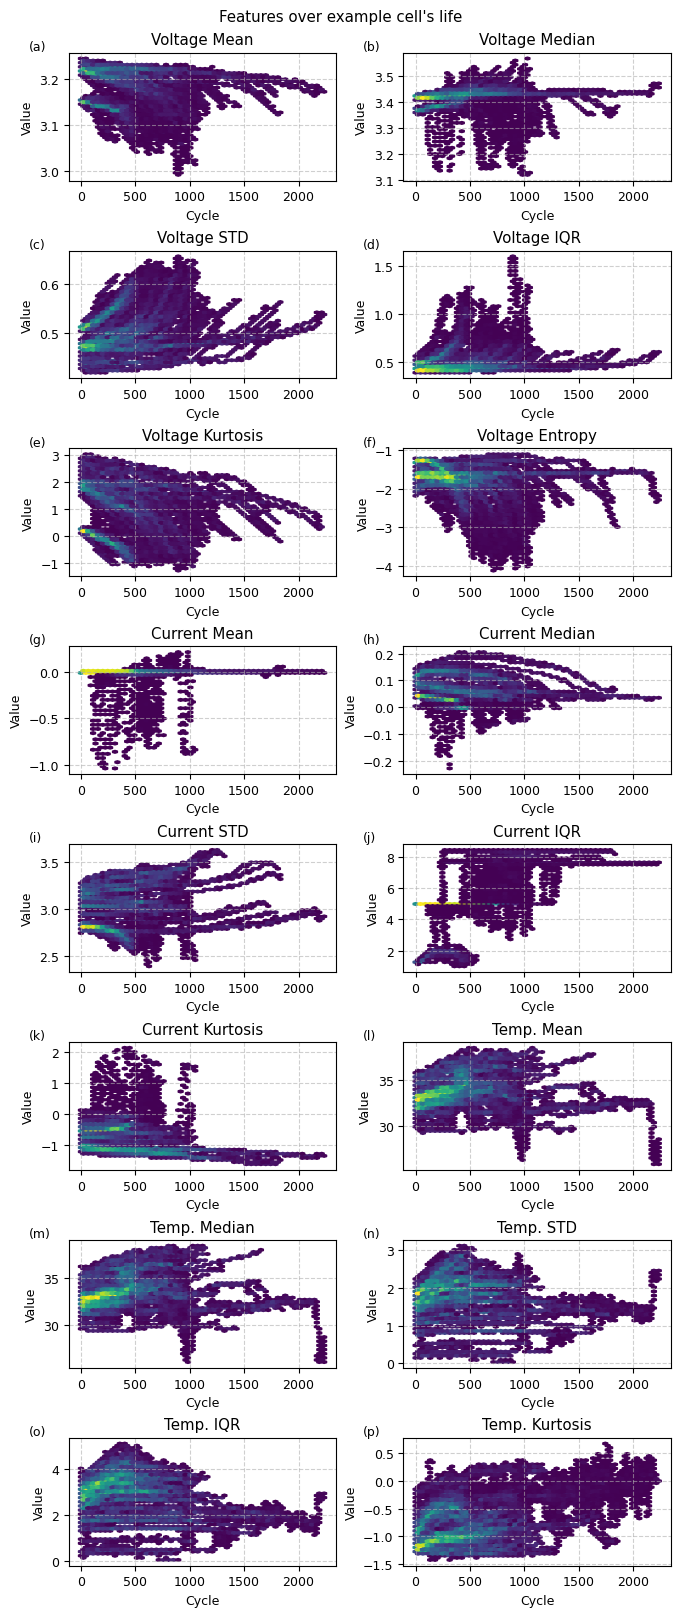

In [32]:
def plot_features_hexbin_for_cycle(
    data: pd.DataFrame,
    save_path: str = 'figures/features_hexbin.png'
    ) -> None:
    """Plot distribution of features for the specified cell."""

    if example_cell not in data['cell'].unique():
        raise Exception(
            f"Example cell {example_cell} "
            "not on train set, can't plot filtred data."
        )

    features = FEATURES_NAMES.keys()
    num_features = len(features)

    fig, axes = get_elsevier_figure_with_subplots(8, 2, column='double', spacing_factor=0.8)
    axes = axes.flatten() if num_features > 1 else [axes]

    letters = [f'({chr(97 + i)})' for i in range(num_features)]

    for index, (feature, ax) in enumerate(zip(features, axes)):
        cycle = data['cycle']
        values = data[feature]
        
        display_name = FEATURES_NAMES.get(feature, feature)

        hb = ax.hexbin(
            cycle, values, gridsize=50, cmap='viridis', mincnt=1
        )

        # Labeling
        display_name = FEATURES_NAMES.get(feature, feature)
        ax.set_title(display_name)
        ax.set_xlabel('Cycle')
        ax.set_ylabel('Value')
        ax.text(-0.15, 1.1, letters[index], transform=ax.transAxes, va='top')
        ax.grid(True, linestyle='--', alpha=0.6)

    # Turn off extra subplots
    for ax in axes[num_features:]:
        ax.axis("off")
    
    fig.suptitle(f"Features over example cell's life")
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

plot_features_hexbin_for_cycle(
    train_df,
    save_path=(
        figures_folder / 'features_hexbin.png'
        if SAVE_FIGURES else None
    )
)

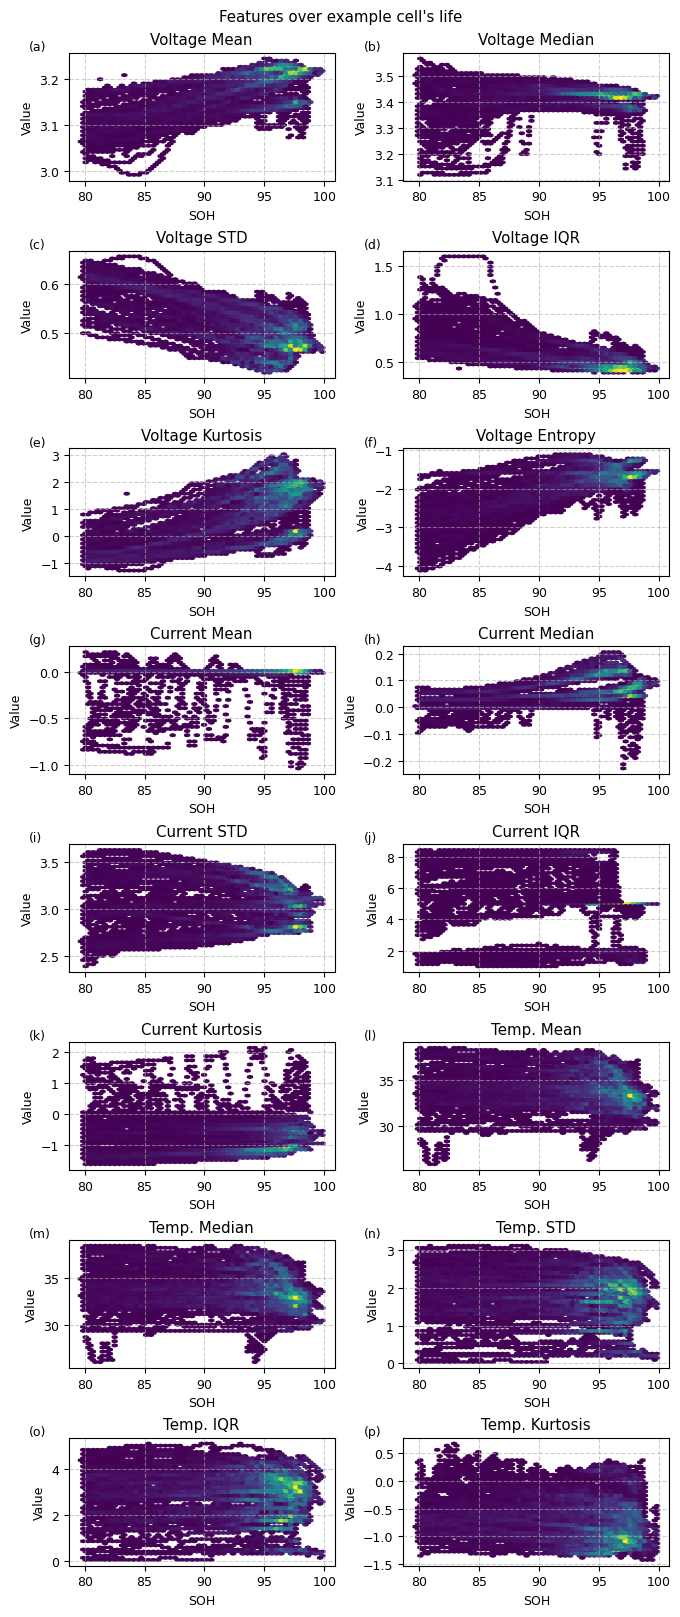

In [33]:
def plot_features_hexbin_for_soh(
    data: pd.DataFrame,
    save_path: str = 'figures/features_hexbin.png'
    ) -> None:
    """Plot distribution of features for the specified cell."""

    if example_cell not in data['cell'].unique():
        raise Exception(
            f"Example cell {example_cell} "
            "not on train set, can't plot filtred data."
        )

    features = FEATURES_NAMES.keys()
    num_features = len(features)

    fig, axes = get_elsevier_figure_with_subplots(8, 2, column='double', spacing_factor=0.8)
    axes = axes.flatten() if num_features > 1 else [axes]

    letters = [f'({chr(97 + i)})' for i in range(num_features)]

    for index, (feature, ax) in enumerate(zip(features, axes)):
        soh = data['SOH']
        values = data[feature]
        
        display_name = FEATURES_NAMES.get(feature, feature)

        hb = ax.hexbin(
            soh, values, gridsize=50, cmap='viridis', mincnt=1
        )

        # Labeling
        display_name = FEATURES_NAMES.get(feature, feature)
        ax.set_title(display_name)
        ax.set_xlabel('SOH')
        ax.set_ylabel('Value')
        ax.text(-0.15, 1.1, letters[index], transform=ax.transAxes, va='top')
        ax.grid(True, linestyle='--', alpha=0.6)

    # Turn off extra subplots
    for ax in axes[num_features:]:
        ax.axis("off")
    
    fig.suptitle(f"Features over example cell's life")
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

plot_features_hexbin_for_soh(
    train_df,
    save_path=(
        figures_folder / 'features_hexbin_soh.png'
        if SAVE_FIGURES else None
    )
)

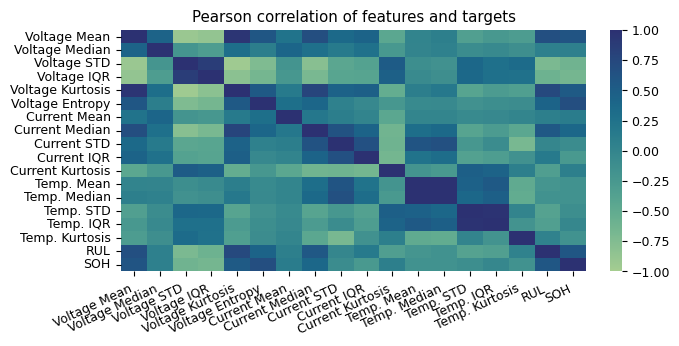

In [ ]:
def plot_correlation_heatmap(
    data: pd.DataFrame, 
    save_path: str = None
    ) -> None:
    """Plot correlation heatmaps for raw and filtered features."""    
    
    # Create plot
    fig, ax = get_elsevier_double_column_fig()

    # Compute correlations
    data.rename(columns=FEATURES_NAMES, inplace=True)
    corr_f = data[list(FEATURES_NAMES.values()) + ['RUL', 'SOH']].corr().round(2)
    
    # Plot heatmaps
    sns.heatmap(corr_f, vmax=1, vmin=-1, ax=ax, cmap='crest')
    
    ax.tick_params(axis='x', labelrotation=25) 
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')
    ax.set_title(
        f'Pearson correlation of features and targets',
        )
    if save_path:
        plt.savefig(save_path, dpi=300)
    
    plt.show()

plot_correlation_heatmap(
    train_df,
    save_path=(
        figures_folder / 'correlation_heatmap.png'
        if SAVE_FIGURES else None
    )
)